In [5]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import linregress
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import json

import psycopg2
import pandas as pd

import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost, getStatValues,density_plot, get_mdfps,density_plot_multiple,train_pred_xgboost_2d
from functools import reduce
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
#disable futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
df = pd.read_csv('mdfp_and_rdkit_features_2980.csv')
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/molregno_to_molblock_2D.pickle', 'rb') as handle:
    molregno_to_molblock_2d = pickle.load(handle)
df['molblock'] = df['molregno'].apply(lambda x: molregno_to_molblock_2d[x])

In [7]:
molblocks = df['molblock'].tolist()
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mol))) for mol in mols]

In [8]:
from serenityff.charge.tree.dash_tree import DASHTree
tree = DASHTree(tree_folder_path="/localhome/cschiebroek/other/props")

Loading DASH tree data


DASHprop features:
1. Min/max/std partial charge
2. Counts: N atom < -0.5, > 0.5
3. HOMO LUMO (mean)

In [9]:
Dash_prop_dict = [tree.get_DASH_feature_dict_for_mol(mol) for mol in mols]

In [10]:
#add these to the dataframe
for key in Dash_prop_dict[0].keys():
    df[key] = [Dash_prop_dict[i][key] for i in range(len(Dash_prop_dict))]
df.to_csv('mdf_rdkit_dash_features_2980.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,confid,molregno,mdfp,vp,NumHeavyAtoms,NumRotatableBonds,NumN,NumO,...,molblock,DASH_homo,DASH_lumo,DASH_max_abs_mbis,DASH_avg_abs_mbis,DASH_>03_abs_mbis,DASH_dual_elec,DASH_dual_nucl,DASH_conj,DASH_num_atoms
0,0,0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",-0.674795,10,1,0,0,...,\n RDKit 2D\n\n 10 10 0 0 0 0...,-0.197156,-0.065572,0.435547,0.181362,0.000000,0.000000,0.0,0.153846,26
1,1,1,2394,2396,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...",-0.907920,7,4,0,1,...,\n RDKit 2D\n\n 7 6 0 0 0 0...,-0.217428,-0.056260,0.687988,0.184390,0.047619,0.047619,0.0,0.000000,21
2,2,2,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",-3.000000,10,2,2,0,...,\n RDKit 2D\n\n 10 10 0 0 0 0...,-0.182138,-0.057069,0.534668,0.238810,0.166667,0.000000,0.0,0.388889,18
3,3,3,2406,2408,"[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...",-6.822020,14,3,4,3,...,\n RDKit 2D\n\n 14 13 0 0 0 0...,-0.190002,-0.117169,0.945801,0.325704,0.208333,0.000000,0.0,0.458333,24
4,4,4,2411,2413,"[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...",-4.772345,15,2,0,1,...,\n RDKit 2D\n\n 15 16 0 0 0 0...,-0.203164,-0.080449,0.331543,0.178319,0.043478,0.000000,0.0,0.565217,23


In [11]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}

In [12]:
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfp_features_full = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
DASH_props_names = [c for c in df.columns.tolist() if 'DASH' in c]
mdfp_2d_features = [f for f in mdfp_features_full if f not in mdfp_features_no_2d]


In [15]:

def train_pred_xgboost_2d_local(df,params,X_features,y_label,splits=5,scale = True):

    X = df[X_features]
    X = X.to_numpy()
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    y = df[y_label]
    kf = KFold(n_splits=splits)
    output = ([], [])

    for train, test in kf.split(X):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)

            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
            )

            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)

    return output,model

In [17]:
import itertools

# define the four feature lists
feature_lists = [RDKit_feature_names, mdfp_features_no_2d, DASH_props_names, mdfp_2d_features]

# generate all possible combinations of the four feature lists
combinations = list(itertools.product(*feature_lists))

# train and predict for each combination
results = []
for combination in combinations:
    X_features = list(combination)
    output, model = train_pred_xgboost_2d_local(df, params=params, X_features=X_features, y_label='vp')
    real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    results.append((X_features, real, prediction))

KeyboardInterrupt: 

In [ ]:
density_plot_multiple(reals = [r[1] for r in results], predictions= [r[2] for r in results], titles = [str(r[0]) for r in results])

In [ ]:
density_plot_multiple

In [13]:
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))

In [14]:
output_mdfp_only = train_pred_xgboost_2d(df,params=params,X_features=mdfp_features_full,y_label='vp')
real_mdfp_only, prediction_mdfp_only = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_only[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_only[1]))

In [17]:
output_physchem_plus_dash = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+DASH_props_names,y_label='vp')
real_physchem_plus_dash, prediction_physchem_plus_dash = (reduce(lambda a,b : list(a)+list(b) , output_physchem_plus_dash[0]), reduce(lambda a,b : list(a)+list(b), output_physchem_plus_dash[1]))

In [18]:
output_mdfp_plus_dash = train_pred_xgboost_2d(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp')
real_mdfp_plus_dash, prediction_mdfp_plus_dash = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_plus_dash[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_plus_dash[1]))

In [19]:
output_dash_only = train_pred_xgboost_2d(df,params=params,X_features=DASH_props_names,y_label='vp')
real_dash_only, prediction_dash_only = (reduce(lambda a,b : list(a)+list(b) , output_dash_only[0]), reduce(lambda a,b : list(a)+list(b), output_dash_only[1]))

Plot 1 Stats:
RMSE:  1.240443470894884
MAE:  0.7626345662548419
R2:  0.8823181720328821
Plot 2 Stats:
RMSE:  1.391616286650359
MAE:  0.8757601463453891
R2:  0.8518169819463116
Plot 3 Stats:
RMSE:  1.2491237266768094
MAE:  0.7760396289901332
R2:  0.8805964991570103
Plot 4 Stats:
RMSE:  1.3357116819325894
MAE:  0.8328656540291711
R2:  0.8634605218729456


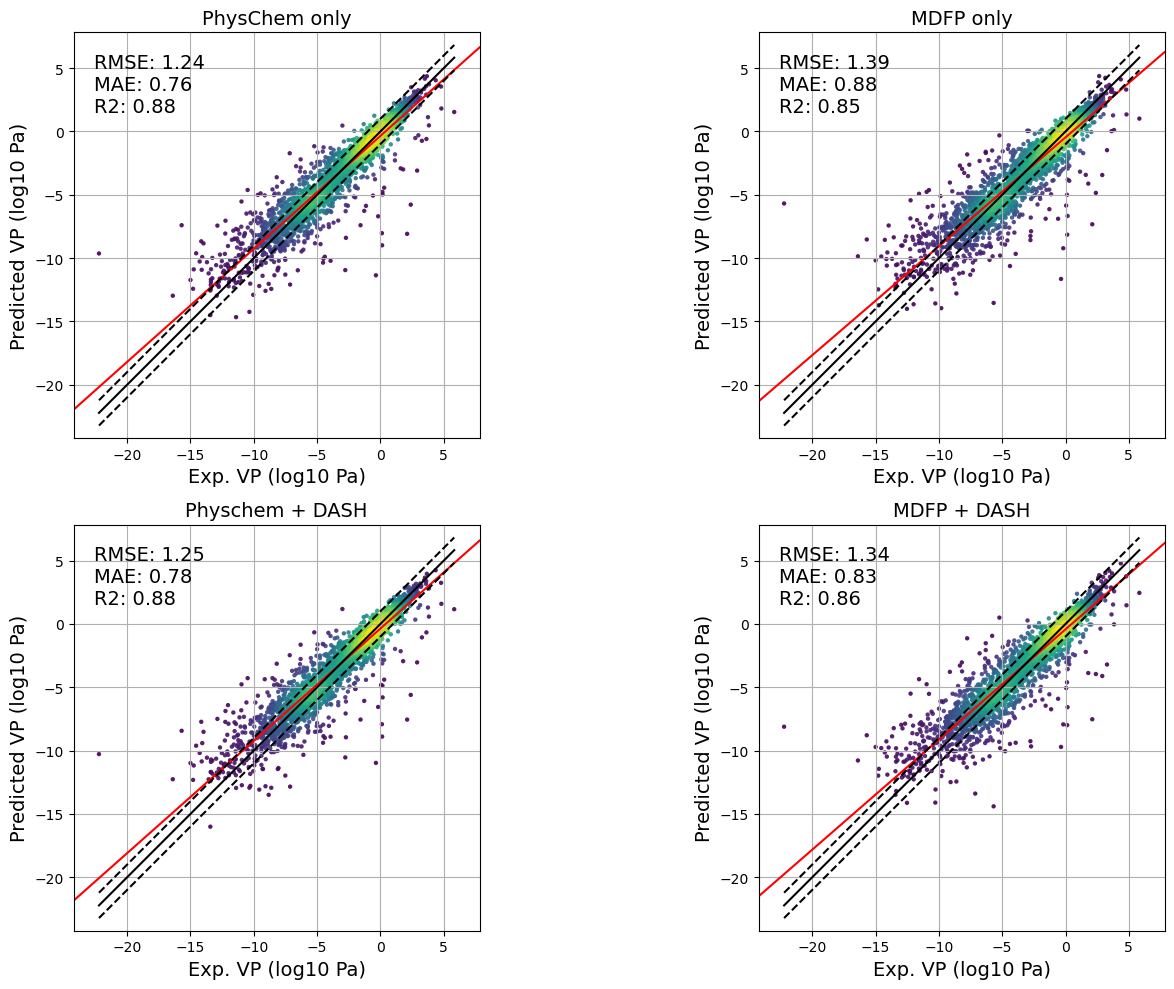

In [22]:
density_plot_multiple(reals = [real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash],
                      predictions = [prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash],
                      titles = ['PhysChem only','MDFP only','Physchem + DASH','MDFP + DASH'])

Plot 1 Stats:
RMSE:  1.240443470894884
MAE:  0.7626345662548419
R2:  0.8823181720328821
Plot 2 Stats:
RMSE:  1.391616286650359
MAE:  0.8757601463453891
R2:  0.8518169819463116
Plot 3 Stats:
RMSE:  1.2491237266768094
MAE:  0.7760396289901332
R2:  0.8805964991570103
Plot 4 Stats:
RMSE:  1.3357116819325894
MAE:  0.8328656540291711
R2:  0.8634605218729456
Plot 5 Stats:
RMSE:  1.6384833943888646
MAE:  1.1590253312573418
R2:  0.7946097394319289


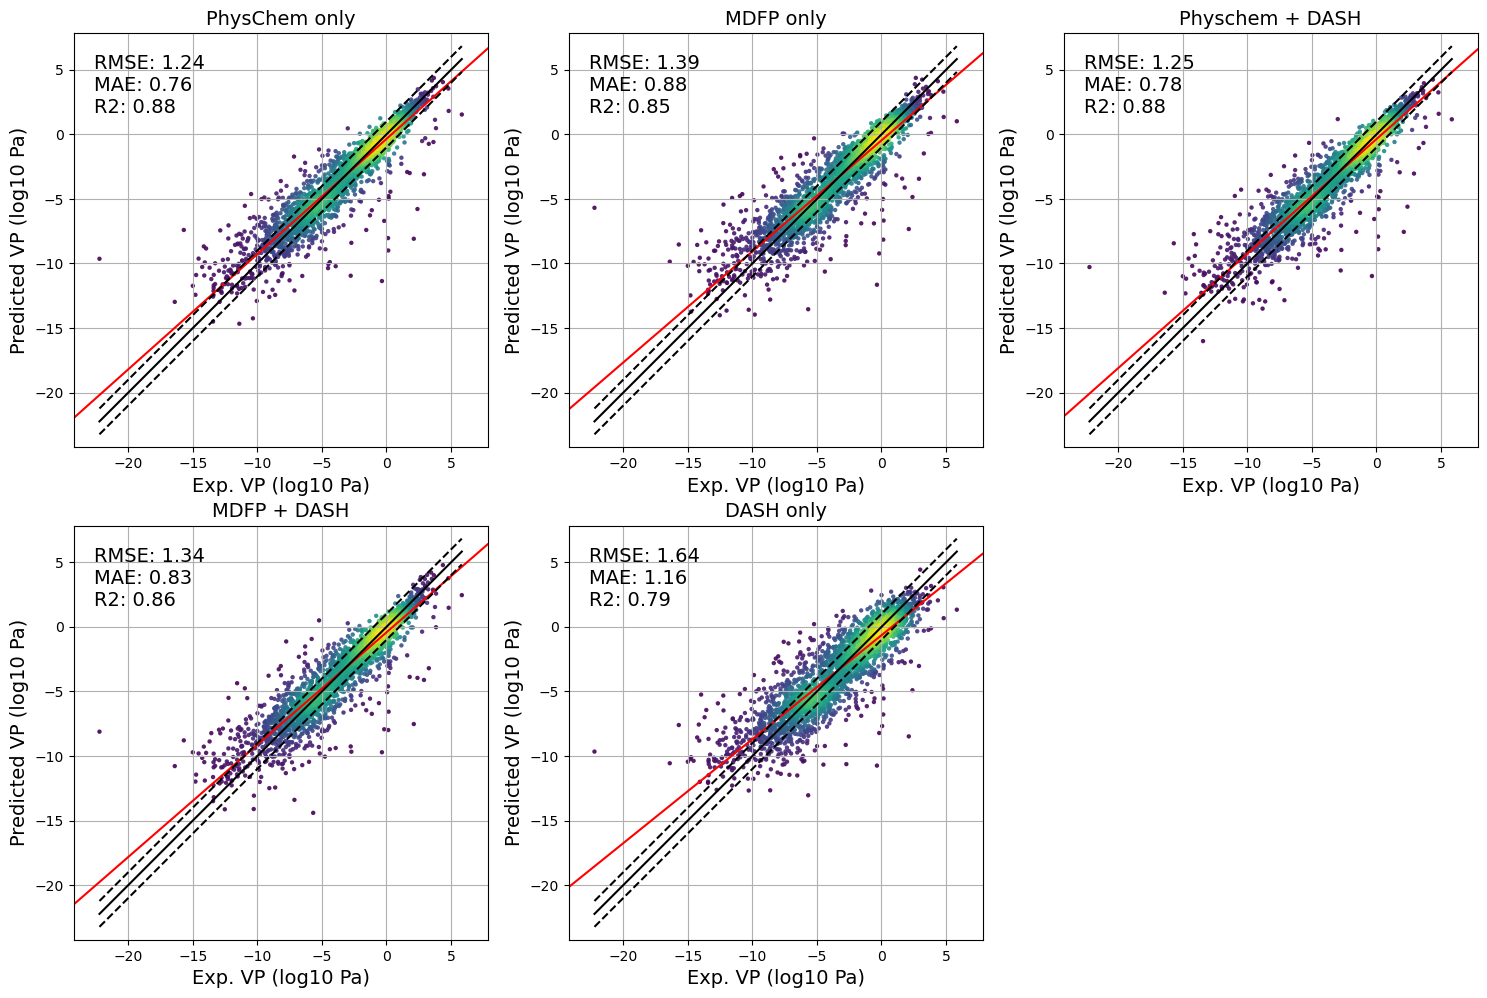

In [38]:
density_plot_multiple(reals = [real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash, real_dash_only],
                      predictions = [prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash, prediction_dash_only],
                      titles = ['PhysChem only','MDFP only','Physchem + DASH','MDFP + DASH','DASH only','DASH + MolWt','MolWt only'])

In [24]:

def train_pred_xgboost_2d_local(df,params,X_features,y_label,splits=5,scale = True):

    X = df[X_features]
    X = X.to_numpy()
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    y = df[y_label]
    kf = KFold(n_splits=splits)
    output = ([], [])

    for train, test in kf.split(X):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)

            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
            )

            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)

    return output,model

In [25]:
output_dash_only,model_dash_only = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp')
importance = model_dash_only.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
importance = {DASH_props_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance



[('DASH_num_atoms', 95.0),
 ('DASH_max_abs_mbis', 88.0),
 ('DASH_homo', 65.0),
 ('DASH_avg_abs_mbis', 65.0),
 ('DASH_lumo', 64.0),
 ('DASH_>03_abs_mbis', 59.0),
 ('DASH_conj', 54.0),
 ('DASH_dual_elec', 19.0),
 ('DASH_dual_nucl', 4.0)]

In [26]:
output_dash_only,model_dash_only = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp')
importance = model_dash_only.get_score(importance_type='gain')
#use actual feature names: DASH_props_names
importance = {DASH_props_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance

[('DASH_num_atoms', 291.7652282714844),
 ('DASH_conj', 252.4527130126953),
 ('DASH_>03_abs_mbis', 84.31073760986328),
 ('DASH_max_abs_mbis', 30.967975616455078),
 ('DASH_lumo', 27.749984741210938),
 ('DASH_avg_abs_mbis', 22.789527893066406),
 ('DASH_dual_elec', 11.293538093566895),
 ('DASH_homo', 11.183746337890625),
 ('DASH_dual_nucl', 9.926115989685059)]

In [27]:
output_mdfp_plus_dash,model_mdfp_plus_dash = train_pred_xgboost_2d_local(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp')
importance = model_mdfp_plus_dash.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
dash_plus_mdfp_names  = mdfp_features_full+DASH_props_names
importance = {dash_plus_mdfp_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance





[('water_total_ene_std', 27.0),
 ('DASH_max_abs_mbis', 27.0),
 ('NumHeavyAtoms', 26.0),
 ('water_total_crf_std', 25.0),
 ('DASH_conj', 25.0),
 ('water_total_lj_std', 22.0),
 ('water_rgyr_mean', 21.0),
 ('water_intra_crf_mean', 20.0),
 ('water_sasa_std', 19.0),
 ('water_total_lj_mean', 18.0),
 ('DASH_avg_abs_mbis', 18.0),
 ('NumRotatableBonds', 16.0),
 ('NumO', 16.0),
 ('water_intra_crf_std', 14.0),
 ('NumN', 13.0),
 ('water_intra_lj_std', 13.0),
 ('water_rgyr_std', 13.0),
 ('DASH_>03_abs_mbis', 13.0),
 ('water_total_ene_mean', 12.0),
 ('DASH_lumo', 12.0),
 ('NumF', 10.0),
 ('water_total_crf_mean', 9.0),
 ('water_rgyr_median', 9.0),
 ('water_intra_lj_mean', 8.0),
 ('water_total_lj_median', 8.0),
 ('water_intra_lj_median', 7.0),
 ('water_intra_ene_std', 7.0),
 ('water_sasa_mean', 7.0),
 ('DASH_homo', 7.0),
 ('DASH_num_atoms', 6.0),
 ('NumS', 4.0),
 ('NumBr', 4.0),
 ('water_intra_ene_mean', 4.0),
 ('DASH_dual_elec', 4.0),
 ('water_total_ene_median', 3.0),
 ('DASH_dual_nucl', 3.0),
 ('NumC

In [28]:
output_mdfp_plus_dash,model_mdfp_plus_dash = train_pred_xgboost_2d_local(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp')
importance = model_mdfp_plus_dash.get_score(importance_type='gain')
#use actual feature names: DASH_props_names
dash_plus_mdfp_names  = mdfp_features_full+DASH_props_names
importance = {dash_plus_mdfp_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance



[('NumHeavyAtoms', 1383.390869140625),
 ('water_total_ene_std', 188.87850952148438),
 ('water_total_crf_std', 117.705810546875),
 ('water_rgyr_median', 96.7692642211914),
 ('water_total_lj_std', 94.8825912475586),
 ('NumF', 94.01069641113281),
 ('DASH_conj', 88.12123107910156),
 ('DASH_>03_abs_mbis', 78.84381866455078),
 ('NumN', 60.929481506347656),
 ('water_sasa_mean', 47.37591552734375),
 ('water_intra_lj_mean', 44.23191833496094),
 ('water_intra_crf_median', 35.39110565185547),
 ('water_rgyr_mean', 33.8806037902832),
 ('NumRotatableBonds', 27.124881744384766),
 ('NumS', 27.097890853881836),
 ('water_intra_lj_median', 26.235713958740234),
 ('NumBr', 24.270597457885742),
 ('water_sasa_std', 15.918705940246582),
 ('water_total_lj_median', 15.400700569152832),
 ('water_intra_ene_std', 14.049492835998535),
 ('DASH_homo', 13.778212547302246),
 ('water_total_crf_mean', 13.030862808227539),
 ('NumCl', 12.971080780029297),
 ('water_intra_crf_mean', 12.65527629852295),
 ('DASH_avg_abs_mbis',

In [29]:
#replace estate by dashprops
custom_estate = RDKit_feature_names.copy()
custom_estate = [f for f in custom_estate if 'EState' not in f]
custom_estate = [f for f in custom_estate if 'Charge' not in f]
custom_estate += DASH_props_names
custom_estate

['qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'S

Plot 1 Stats:
RMSE:  1.240443470894884
MAE:  0.7626345662548419
R2:  0.8823181720328821
Plot 2 Stats:
RMSE:  1.2390155963843135
MAE:  0.7670493572683449
R2:  0.8825691747523656


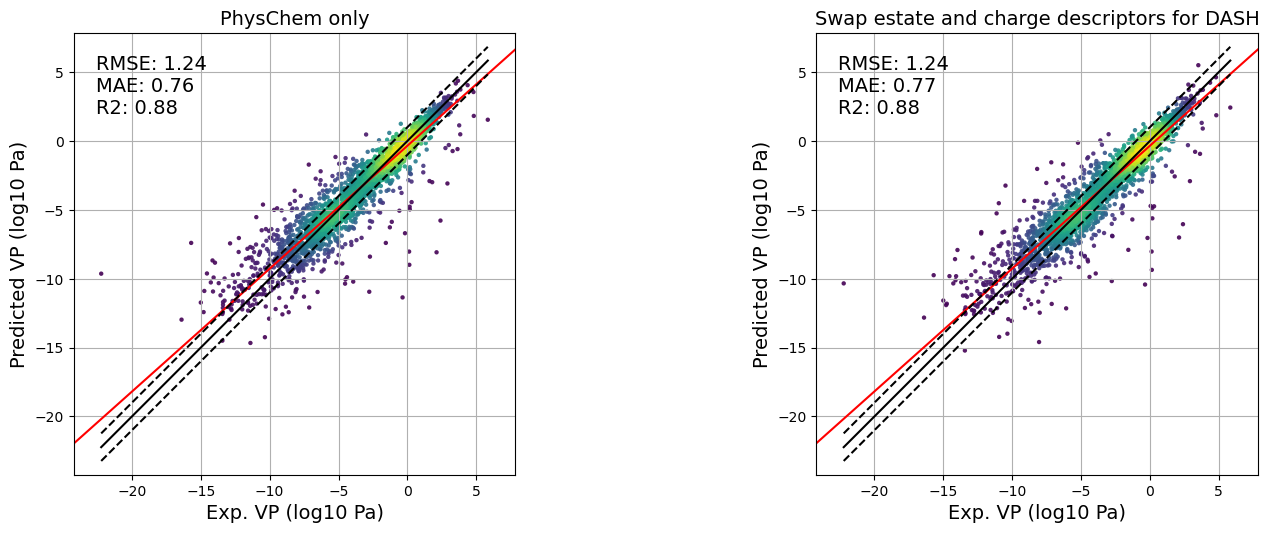

In [30]:
custom_estate_out,model_custom_estate = train_pred_xgboost_2d_local(df,params=params,X_features=custom_estate,y_label='vp')
realcustom_estate, prediction_custom_estate = (reduce(lambda a,b : list(a)+list(b) , custom_estate_out[0]), reduce(lambda a,b : list(a)+list(b), custom_estate_out[1]))
density_plot_multiple(reals = [real_2d_only,realcustom_estate],
                      predictions = [prediction_2d_only,prediction_custom_estate],
                      titles = ['PhysChem only','Swap estate and charge descriptors for DASH'])

In [31]:
importance = model_custom_estate.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
importance = {custom_estate[int(k[1:])]:v for k,v in importance.items()}
importance_list = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance_list



[('TPSA', 13.0),
 ('Chi1v', 10.0),
 ('NHOHCount', 10.0),
 ('BalabanJ', 8.0),
 ('SMR_VSA2', 8.0),
 ('AvgIpc', 7.0),
 ('PEOE_VSA10', 7.0),
 ('PEOE_VSA14', 7.0),
 ('SMR_VSA10', 7.0),
 ('MolMR', 7.0),
 ('DASH_avg_abs_mbis', 7.0),
 ('Chi2n', 6.0),
 ('Chi3n', 6.0),
 ('FpDensityMorgan3', 5.0),
 ('Chi4v', 5.0),
 ('PEOE_VSA3', 5.0),
 ('SlogP_VSA8', 5.0),
 ('NumHDonors', 5.0),
 ('DASH_max_abs_mbis', 5.0),
 ('qed', 4.0),
 ('BCUT2D_CHGHI', 4.0),
 ('BCUT2D_CHGLO', 4.0),
 ('BCUT2D_LOGPHI', 4.0),
 ('BCUT2D_LOGPLOW', 4.0),
 ('BCUT2D_MRLOW', 4.0),
 ('Chi0v', 4.0),
 ('HallKierAlpha', 4.0),
 ('Kappa1', 4.0),
 ('Kappa2', 4.0),
 ('PEOE_VSA1', 4.0),
 ('PEOE_VSA7', 4.0),
 ('PEOE_VSA8', 4.0),
 ('SMR_VSA4', 4.0),
 ('SlogP_VSA3', 4.0),
 ('HeavyAtomCount', 4.0),
 ('MolLogP', 4.0),
 ('fr_Ar_N', 4.0),
 ('DASH_lumo', 4.0),
 ('DASH_>03_abs_mbis', 4.0),
 ('DASH_conj', 4.0),
 ('FpDensityMorgan1', 3.0),
 ('BCUT2D_MWHI', 3.0),
 ('BCUT2D_MWLOW', 3.0),
 ('BertzCT', 3.0),
 ('Chi4n', 3.0),
 ('Kappa3', 3.0),
 ('PEOE_VSA2', 3

RMSE:  1.4181028750540308
MAE:  0.9012654301781801
R2:  0.8461916414562451


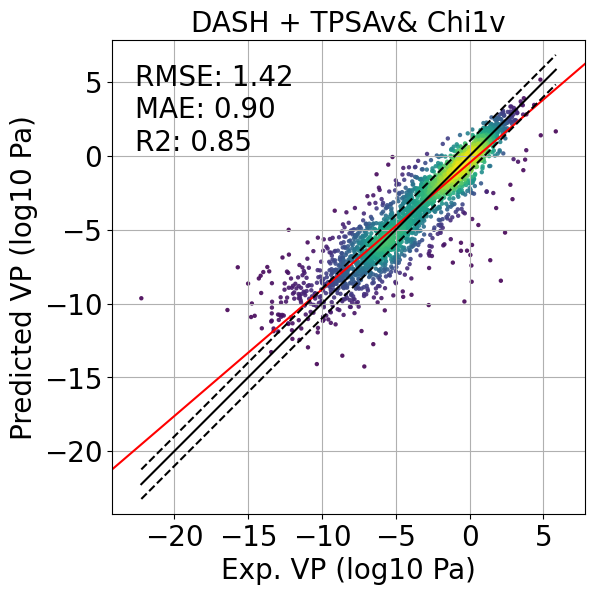

In [45]:
custom_features = DASH_props_names + ['TPSA','Chi1v']
output_mdfp_custom_features,model_mdfp_custom_features = train_pred_xgboost_2d_local(df,params=params,X_features=custom_features,y_label='vp')
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_custom_features[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_custom_features[1]))
density_plot(real = real, prediction = prediction, title = 'DASH + TPSAv& Chi1v')


Plot 1 Stats:
RMSE:  1.6384833943888646
MAE:  1.1590253312573418
R2:  0.7946097394319289
Plot 2 Stats:
RMSE:  1.5813201805280959
MAE:  1.0569746402375009
R2:  0.8086503940279982
Plot 3 Stats:
RMSE:  1.6227833555121987
MAE:  1.0795199176864991
R2:  0.7984717298923314


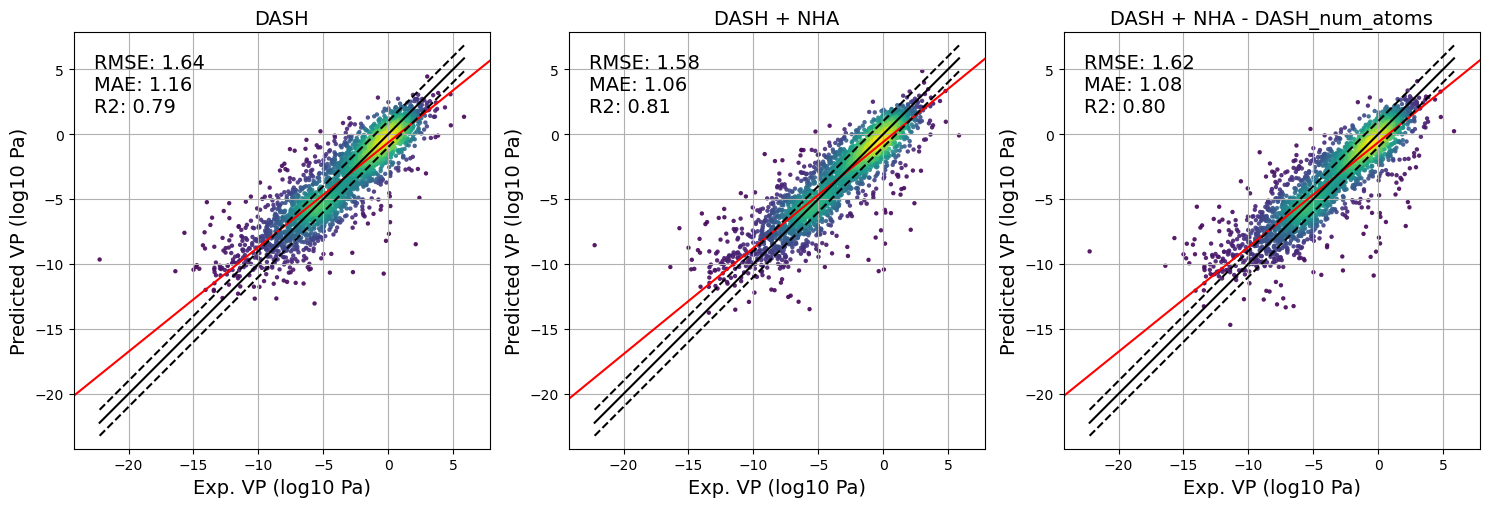

In [52]:
custom_features_nha = DASH_props_names + ['NumHeavyAtoms']
custom_features_rm_na = custom_features_nha.copy()
custom_features_rm_na.remove('DASH_num_atoms')
output_dash,model_dash = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp')
real_dash, prediction_dash = (reduce(lambda a,b : list(a)+list(b) , output_dash[0]), reduce(lambda a,b : list(a)+list(b), output_dash[1]))

output_dash_nha ,model_dash_nha = train_pred_xgboost_2d_local(df,params=params,X_features=custom_features_nha,y_label='vp')
real_dash_nha, prediction_dash_nha = (reduce(lambda a,b : list(a)+list(b) , output_dash_nha[0]), reduce(lambda a,b : list(a)+list(b), output_dash_nha[1]))

output_dash_rm_ha ,model_dash_rm_ha = train_pred_xgboost_2d_local(df,params=params,X_features=custom_features_rm_na,y_label='vp')
real_dash_rm_ha, prediction_dash_rm_ha = (reduce(lambda a,b : list(a)+list(b) , output_dash_rm_ha[0]), reduce(lambda a,b : list(a)+list(b), output_dash_rm_ha[1]))

density_plot_multiple(reals = [real_dash,real_dash_nha,real_dash_rm_ha],predictions=[prediction_dash,prediction_dash_nha,prediction_dash_rm_ha],titles=['DASH','DASH + NHA','DASH + NHA - DASH_num_atoms'])

Plot 1 Stats:
RMSE:  1.6384833943888646
MAE:  1.1590253312573418
R2:  0.7946097394319289
Plot 2 Stats:
RMSE:  1.3750007803477766
MAE:  0.8945843265557698
R2:  0.8552848390814858
Plot 3 Stats:
RMSE:  1.240443470894884
MAE:  0.7626345662548419
R2:  0.8823181720328821
Plot 4 Stats:
RMSE:  1.36021527281208
MAE:  0.8820673943381369
R2:  0.8583686907617781


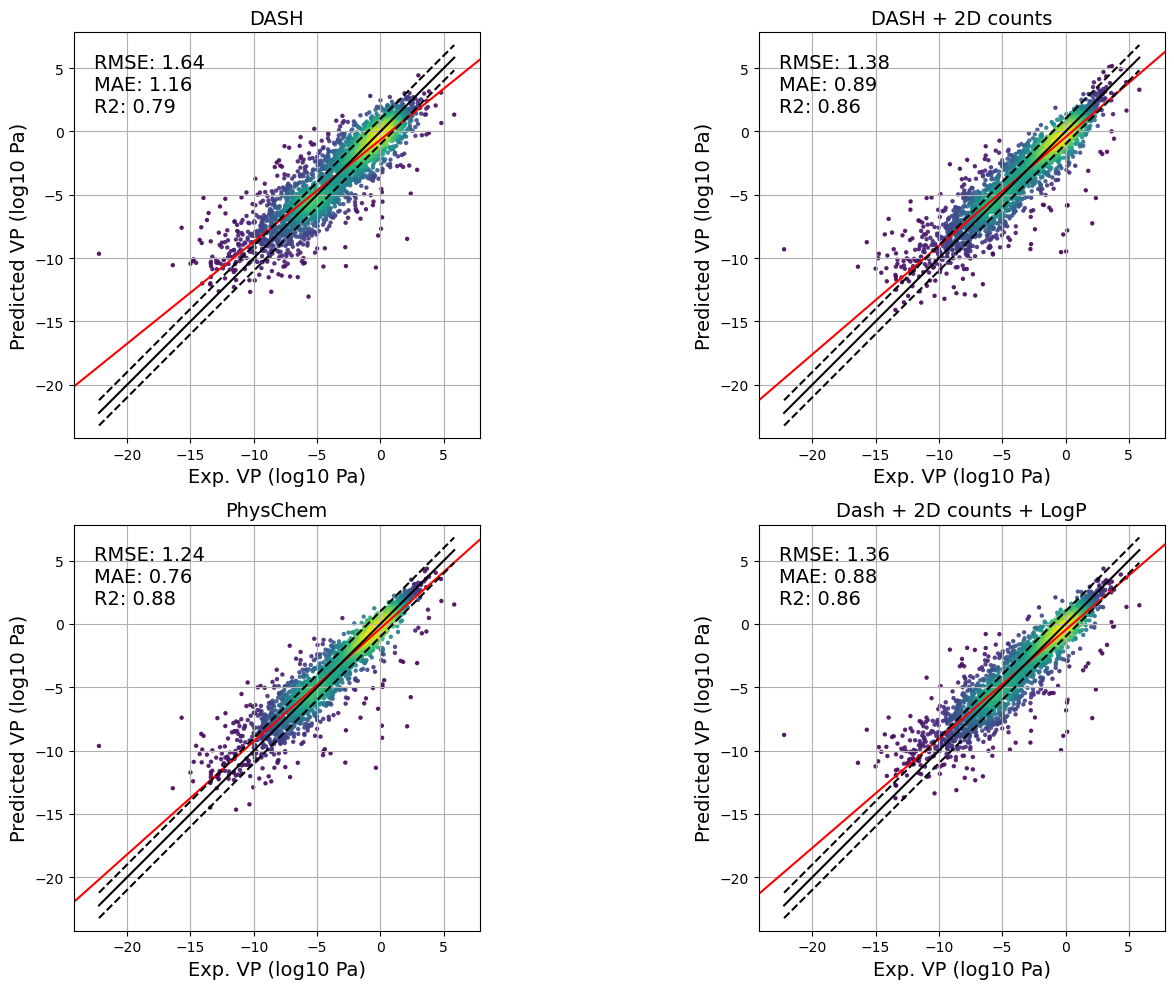

In [59]:
dash_plus_2d_counts = DASH_props_names + mdfp_2d_features
output_dash_plus_2d_counts ,model_dash_plus_2d_counts = train_pred_xgboost_2d_local(df,params=params,X_features=dash_plus_2d_counts,y_label='vp')
real_dash_plus_2d_counts, prediction_dash_plus_2d_counts = (reduce(lambda a,b : list(a)+list(b) , output_dash_plus_2d_counts[0]), reduce(lambda a,b : list(a)+list(b), output_dash_plus_2d_counts[1]))

dash_plus_2d_counts_plus_logp= DASH_props_names + mdfp_2d_features + ['AvgIpc']
output_dash_plus_2d_counts_plus_logp ,model_dash_plus_2d_counts_plus_logp = train_pred_xgboost_2d_local(df,params=params,X_features=dash_plus_2d_counts_plus_logp,y_label='vp')
real_dash_plus_2d_counts_plus_logp, prediction_dash_plus_2d_counts_plus_logp = (reduce(lambda a,b : list(a)+list(b) , output_dash_plus_2d_counts_plus_logp[0]), reduce(lambda a,b : list(a)+list(b), output_dash_plus_2d_counts_plus_logp[1]))


density_plot_multiple(reals=[real_dash,real_dash_plus_2d_counts,real_2d_only,real_dash_plus_2d_counts_plus_logp],predictions=[prediction_dash,prediction_dash_plus_2d_counts,prediction_2d_only,prediction_dash_plus_2d_counts_plus_logp],titles=['DASH','DASH + 2D counts','PhysChem','Dash + 2D counts + LogP'])



In [64]:
for f in RDKit_feature_names:
    dash_plus_2d_counts_plus_logp= DASH_props_names + mdfp_2d_features + [f]
    output_dash_plus_2d_counts_plus_logp ,model_dash_plus_2d_counts_plus_logp = train_pred_xgboost_2d_local(df,params=params,X_features=dash_plus_2d_counts_plus_logp,y_label='vp')
    real_dash_plus_2d_counts_plus_logp, prediction_dash_plus_2d_counts_plus_logp = (reduce(lambda a,b : list(a)+list(b) , output_dash_plus_2d_counts_plus_logp[0]), reduce(lambda a,b : list(a)+list(b), output_dash_plus_2d_counts_plus_logp[1]))
    slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(real_dash_plus_2d_counts_plus_logp, prediction_dash_plus_2d_counts_plus_logp)
    if this_mae < 0.89 and this_rmse < 1.38 and r2 > 0.86:
        print(f)
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)

MinPartialCharge
RMSE:  1.3311198394173
MAE:  0.8470305254508496
R2:  0.8643561494999754
MaxAbsPartialCharge
RMSE:  1.3404735875939795
MAE:  0.8564698993604681
R2:  0.862442030573833
PEOE_VSA13
RMSE:  1.3264553405596025
MAE:  0.8568149408103888
R2:  0.8653042519081284
SMR_VSA2
RMSE:  1.3338811588831159
MAE:  0.841477955135245
R2:  0.8638015843305845
SlogP_VSA8
RMSE:  1.341974610168315
MAE:  0.862656072081443
R2:  0.8621241536354352
NHOHCount
RMSE:  1.3248715824073856
MAE:  0.8383100916553503
R2:  0.8656329917021875
NumHDonors
RMSE:  1.3130726919549192
MAE:  0.8261523620553344
R2:  0.8680182131559466
NumSaturatedCarbocycles
RMSE:  1.3502064565597205
MAE:  0.8763040757309911
R2:  0.8604517056949352
fr_COO2
RMSE:  1.351184901640305
MAE:  0.8767738535334587
R2:  0.8602379000514664
fr_ester
RMSE:  1.3507008259989721
MAE:  0.8728473517273351
R2:  0.860354249612512


Plot 1 Stats:
RMSE:  1.6384833943888646
MAE:  1.1590253312573418
R2:  0.7946097394319289
Plot 2 Stats:
RMSE:  1.3750007803477766
MAE:  0.8945843265557698
R2:  0.8552848390814858
Plot 3 Stats:
RMSE:  1.240443470894884
MAE:  0.7626345662548419
R2:  0.8823181720328821
Plot 4 Stats:
RMSE:  1.3597029062435597
MAE:  0.8902082401745723
R2:  0.8584956804874043
Plot 5 Stats:
RMSE:  1.2419035125922284
MAE:  0.7672455194258986
R2:  0.8819544964075716
Plot 6 Stats:
RMSE:  1.2499400520533672
MAE:  0.7737626825237458
R2:  0.8806249998325383


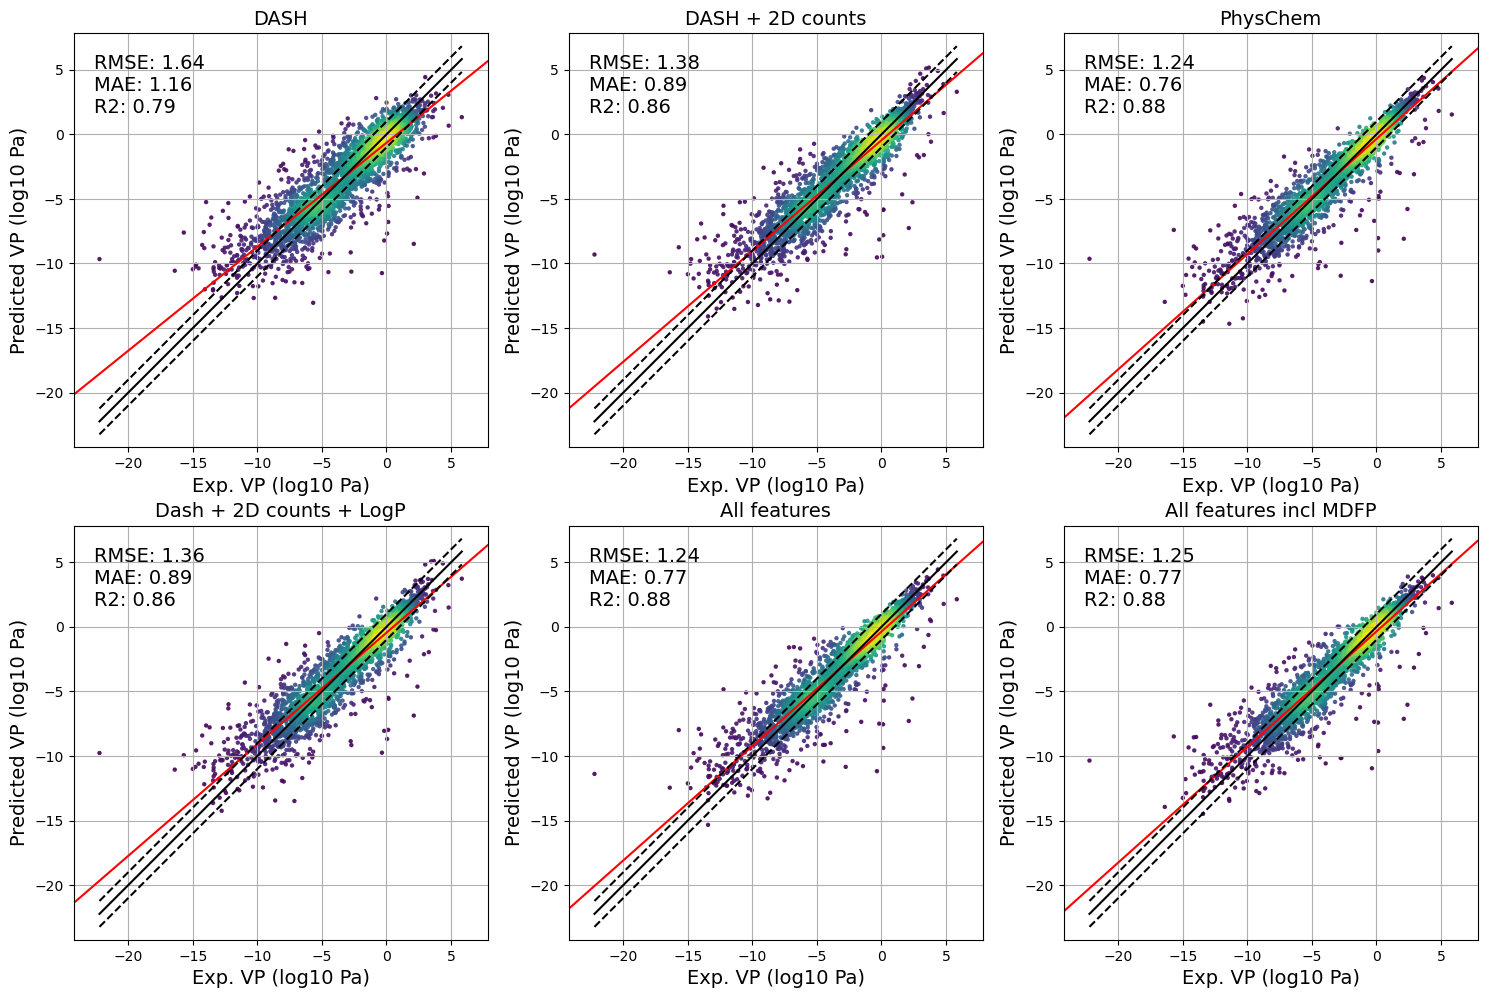

In [65]:
all_features = DASH_props_names + mdfp_2d_features + RDKit_feature_names
output_all_features ,model_all_features = train_pred_xgboost_2d_local(df,params=params,X_features=all_features,y_label='vp')
real_all_features, prediction_all_features = (reduce(lambda a,b : list(a)+list(b) , output_all_features[0]), reduce(lambda a,b : list(a)+list(b), output_all_features[1]))

all_features_incl_mdfp = DASH_props_names + mdfp_features_full + RDKit_feature_names
output_all_features_incl_mdfp ,model_all_features_incl_mdfp = train_pred_xgboost_2d_local(df,params=params,X_features=all_features_incl_mdfp,y_label='vp')
real_all_features_incl_mdfp, prediction_all_features_incl_mdfp = (reduce(lambda a,b : list(a)+list(b) , output_all_features_incl_mdfp[0]), reduce(lambda a,b : list(a)+list(b), output_all_features_incl_mdfp[1]))

density_plot_multiple(reals=[real_dash,real_dash_plus_2d_counts,real_2d_only,real_dash_plus_2d_counts_plus_logp,real_all_features,real_all_features_incl_mdfp],predictions=[prediction_dash,prediction_dash_plus_2d_counts,prediction_2d_only,prediction_dash_plus_2d_counts_plus_logp,prediction_all_features,prediction_all_features_incl_mdfp],titles=['DASH','DASH + 2D counts','PhysChem','Dash + 2D counts + LogP','All features','All features incl MDFP'])


In [66]:
importance = model_all_features.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
all_features_names  = all_features
importance = {all_features_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance

[('Chi1v', 15.0),
 ('TPSA', 11.0),
 ('AvgIpc', 10.0),
 ('MinAbsEStateIndex', 9.0),
 ('BalabanJ', 9.0),
 ('DASH_avg_abs_mbis', 8.0),
 ('DASH_lumo', 7.0),
 ('MinPartialCharge', 7.0),
 ('BCUT2D_CHGLO', 7.0),
 ('Chi2n', 7.0),
 ('Kappa1', 7.0),
 ('SMR_VSA2', 7.0),
 ('NHOHCount', 7.0),
 ('qed', 6.0),
 ('BCUT2D_MWLOW', 6.0),
 ('Kappa2', 6.0),
 ('PEOE_VSA10', 6.0),
 ('PEOE_VSA7', 6.0),
 ('SMR_VSA4', 6.0),
 ('DASH_max_abs_mbis', 5.0),
 ('DASH_>03_abs_mbis', 5.0),
 ('NumHeavyAtoms', 5.0),
 ('MinEStateIndex', 5.0),
 ('PEOE_VSA9', 5.0),
 ('SlogP_VSA2', 5.0),
 ('VSA_EState3', 5.0),
 ('VSA_EState5', 5.0),
 ('VSA_EState8', 5.0),
 ('fr_amide', 5.0),
 ('MaxPartialCharge', 4.0),
 ('FpDensityMorgan2', 4.0),
 ('FpDensityMorgan3', 4.0),
 ('BCUT2D_LOGPHI', 4.0),
 ('BCUT2D_LOGPLOW', 4.0),
 ('Chi0v', 4.0),
 ('Chi3v', 4.0),
 ('Chi4n', 4.0),
 ('Kappa3', 4.0),
 ('PEOE_VSA3', 4.0),
 ('PEOE_VSA8', 4.0),
 ('SlogP_VSA8', 4.0),
 ('VSA_EState4', 4.0),
 ('VSA_EState6', 4.0),
 ('MolLogP', 4.0),
 ('MolMR', 4.0),
 ('fr_bi

In [55]:
mdfp_2d_features

['NumHeavyAtoms',
 'NumRotatableBonds',
 'NumN',
 'NumO',
 'NumF',
 'NumP',
 'NumS',
 'NumCl',
 'NumBr',
 'NumI']

We have the following features:
1. 2D counts
2. MDFP
3. PhysChem
4. DASH
Lets plot all possibilities

In [4]:
import pandas as pd
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfp_features_full = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
DASH_props_names = [c for c in df.columns.tolist() if 'DASH' in c]
mdfp_2d_features = [f for f in mdfp_features_full if f not in mdfp_features_full]

NameError: name 'df' is not defined

In [1]:
density_plot_multiple(reals=[real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash, real_dash_only],
                      predictions=[prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash, prediction_dash_only],
                      titles=['2D only','MDFP only','PhysChem + DASH','MDFP + DASH','DASH only'])


NameError: name 'density_plot_multiple' is not defined